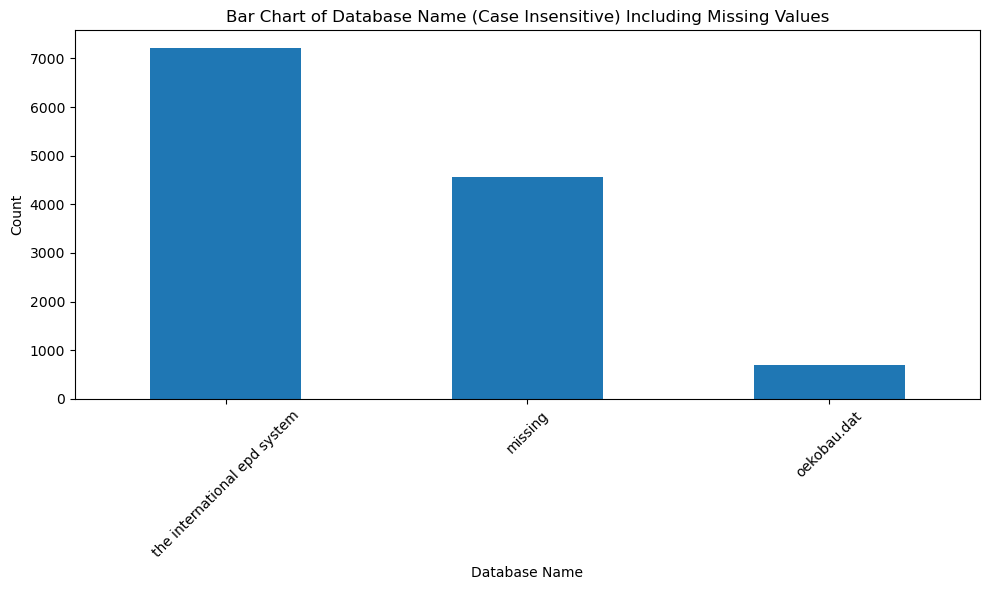

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = "../../data/pipeline2/sql/filtered_epd_data04.csv"
df = pd.read_csv(file_path)

# Replace missing database names with a placeholder and convert to lowercase
df['Database Name Lower'] = df['Database Name'].fillna("Missing").str.lower()

# Count the occurrences of each unique database name (case insensitive)
db_counts = df['Database Name Lower'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
db_counts.plot(kind='bar')
plt.xlabel('Database Name')
plt.ylabel('Count')
plt.title('Bar Chart of Database Name (Case Insensitive) Including Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Georgi\AppData\Local\Temp\ipykernel_13556\2001558195.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


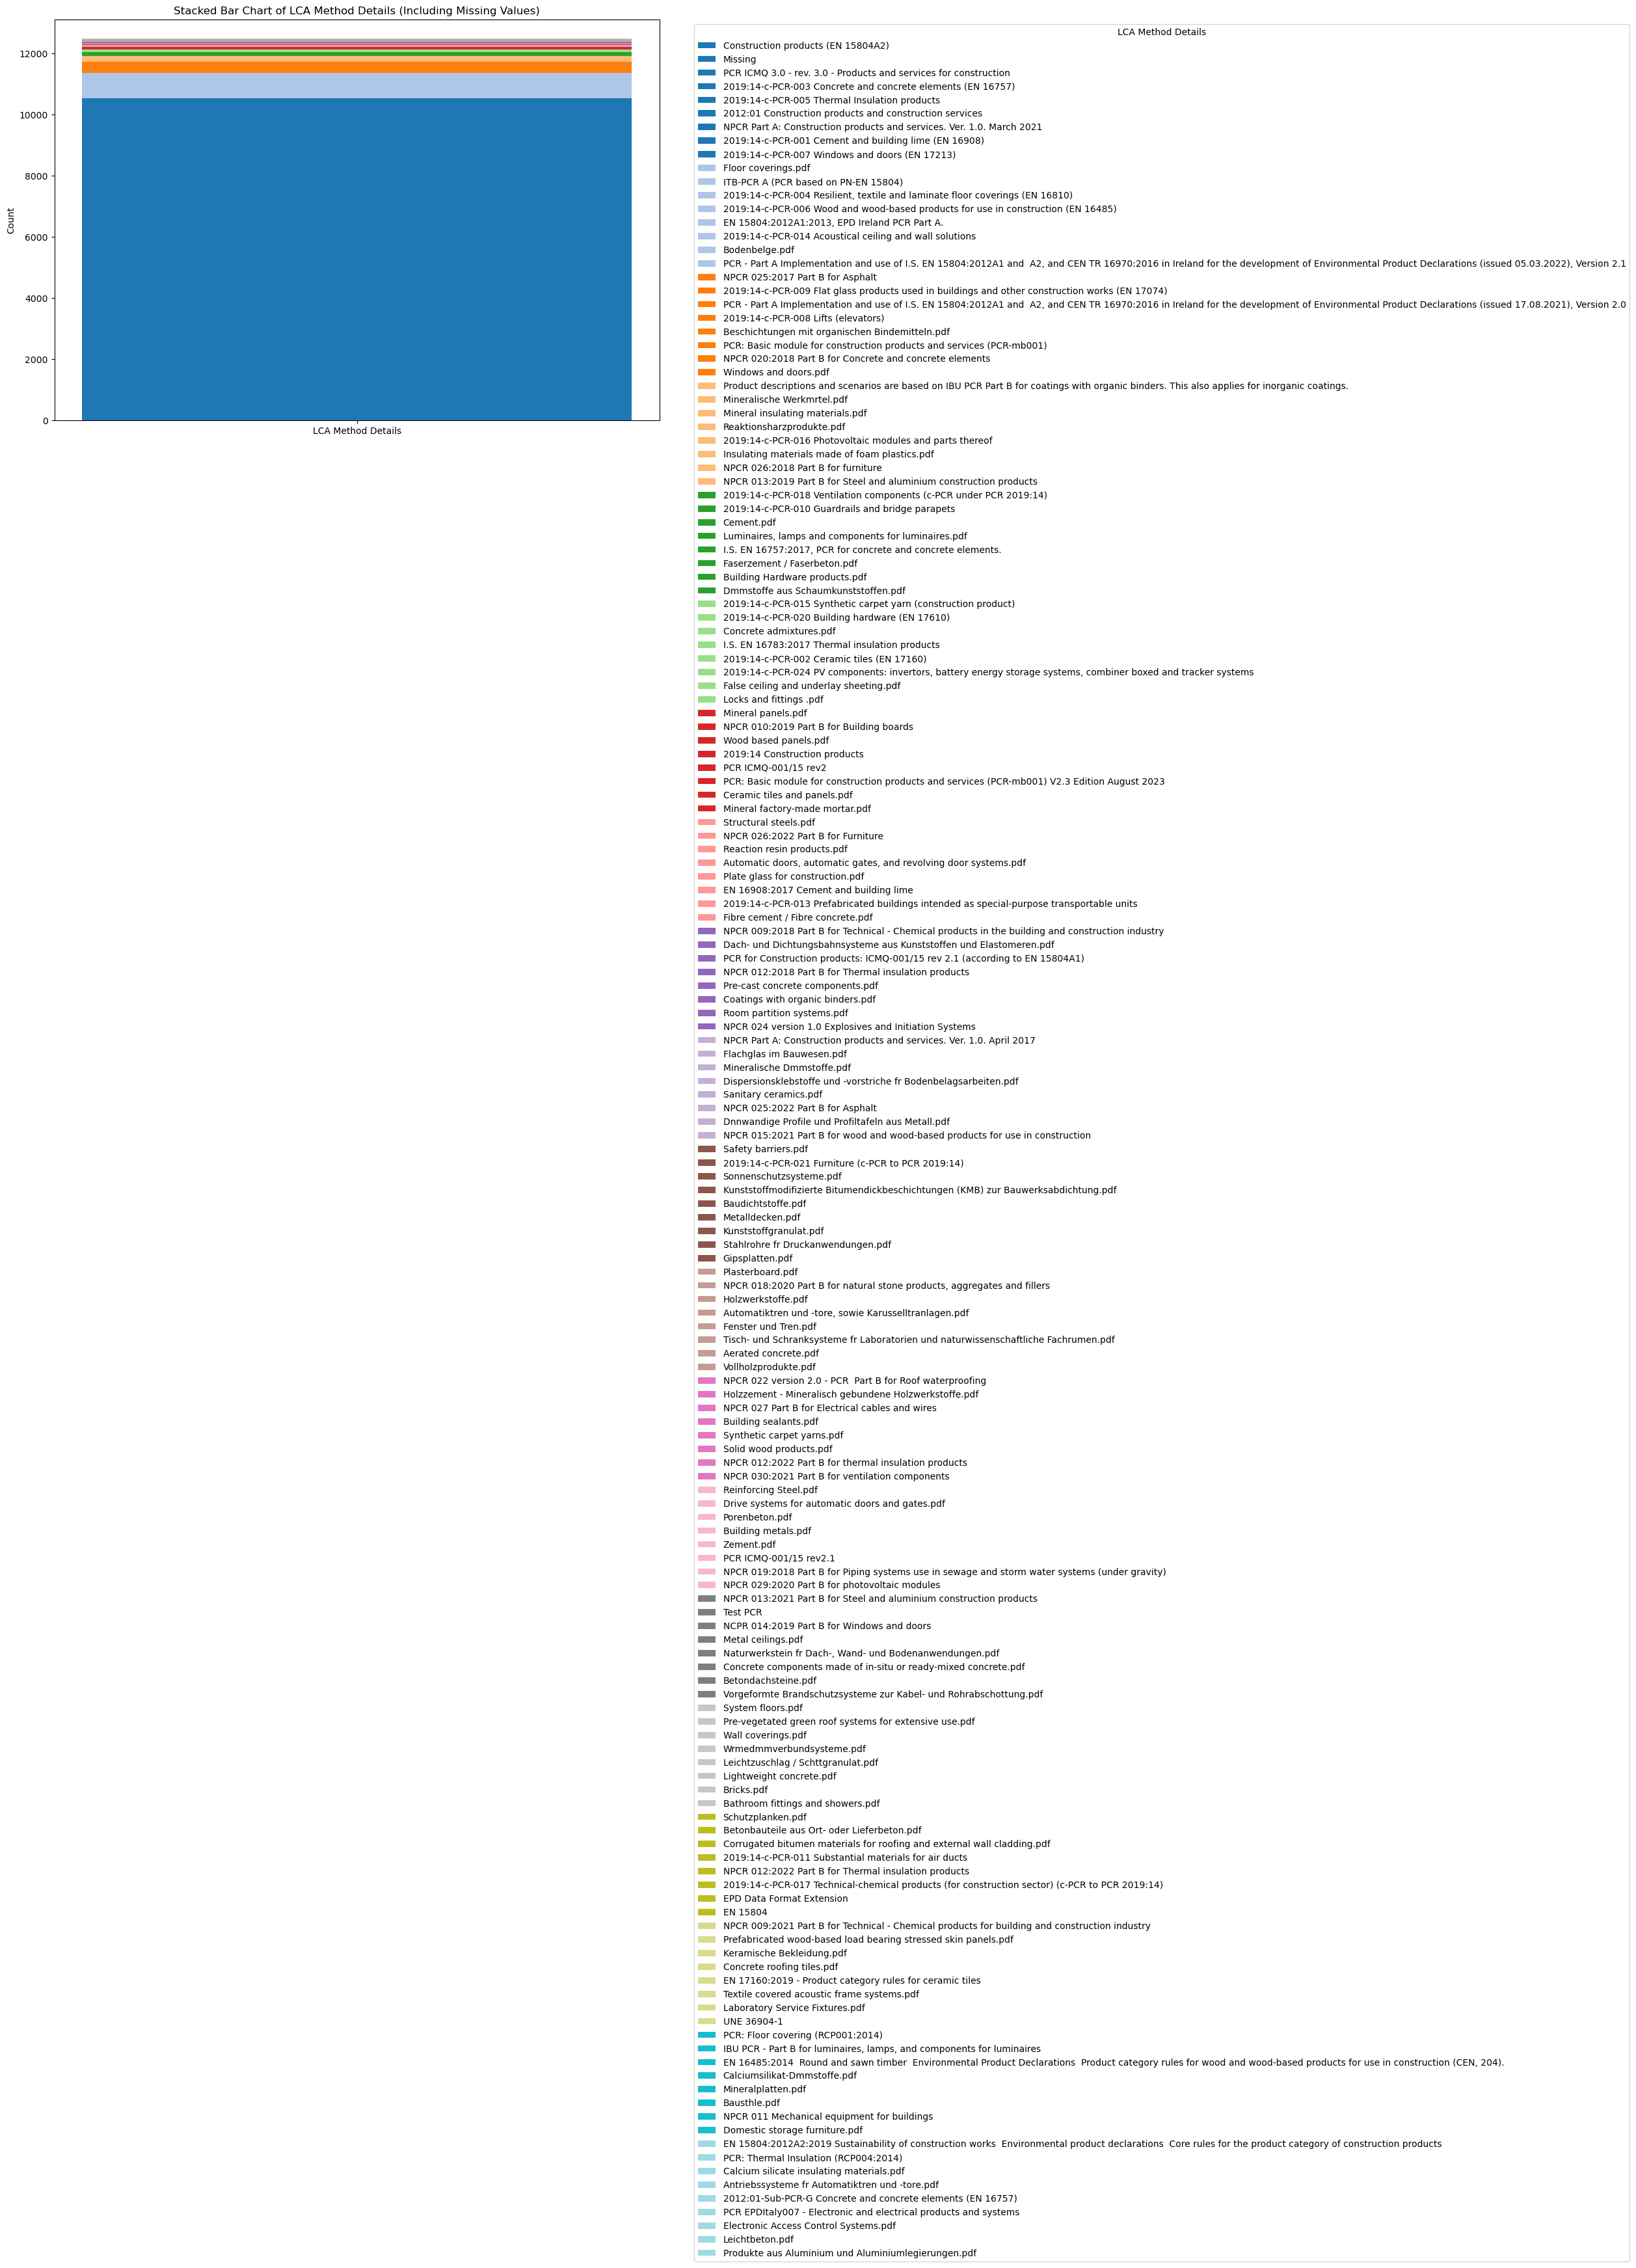

Counts for each LCA Method Details:
Construction products (EN 15804A2): 5659
Missing: 1935
PCR ICMQ 3.0 - rev. 3.0 - Products and services for construction: 1039
2019:14-c-PCR-003 Concrete and concrete elements (EN 16757): 621
2019:14-c-PCR-005 Thermal Insulation products: 439
2012:01 Construction products and construction services: 244
NPCR Part A: Construction products and services. Ver. 1.0. March 2021: 216
2019:14-c-PCR-001 Cement and building lime (EN 16908): 192
2019:14-c-PCR-007 Windows and doors (EN 17213): 175
Floor coverings.pdf: 142
ITB-PCR A (PCR based on PN-EN 15804): 134
2019:14-c-PCR-004 Resilient, textile and laminate floor coverings (EN 16810): 122
2019:14-c-PCR-006 Wood and wood-based products for use in construction (EN 16485): 119
EN 15804:2012A1:2013, EPD Ireland PCR Part A.: 105
2019:14-c-PCR-014 Acoustical ceiling and wall solutions: 91
Bodenbelge.pdf: 61
PCR - Part A Implementation and use of I.S. EN 15804:2012A1 and  A2, and CEN TR 16970:2016 in Ireland for the

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = "../../data/pipeline2/sql/filtered_epd_data04.csv"
df = pd.read_csv(file_path)

# Replace missing LCA Method Details with a placeholder "Missing"
df['LCA Method Details Clean'] = df['LCA Method Details'].fillna("Missing")

# Count the occurrences of each unique LCA Method Details value
lca_counts = df['LCA Method Details Clean'].value_counts()

# Get distinct colors from the tab20 colormap
cmap = plt.get_cmap("tab20", len(lca_counts))
colors = [cmap(i) for i in range(len(lca_counts))]

# Create a stacked bar chart with a single bar segmented by each category
fig, ax = plt.subplots(figsize=(12, 8))
left = 0  # starting point for stacking each segment

for cat, count, color in zip(lca_counts.index, lca_counts.values, colors):
    ax.bar("LCA Method Details", count, bottom=left, color=color, label=cat)
    left += count

ax.set_ylabel("Count")
ax.set_title("Stacked Bar Chart of LCA Method Details (Including Missing Values)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="LCA Method Details")
plt.tight_layout()
plt.show()

# Print the counts for each LCA Method Details
print("Counts for each LCA Method Details:")
for category, count in lca_counts.items():
    print(f"{category}: {count}")


In [1]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. READ AND CLEAN DATA
# ------------------------------------------------------------
file_path = "../../data/pipeline2/sql/filtered_epd_data05.csv"
df = pd.read_csv(file_path)

# Working column for the LCA Method Details
df["LCA_Method"] = df["LCA Method Details"].fillna("Missing")

# ------------------------------------------------------------
# 2. IDENTIFY SMALL CATEGORIES AND MERGE THEM
# ------------------------------------------------------------
THRESHOLD = 20  # categories with fewer than 20 items become "Other"
category_counts = df["LCA_Method"].value_counts()
small_categories = category_counts[category_counts < THRESHOLD].index
df["PCR_Group"] = df["LCA_Method"].where(~df["LCA_Method"].isin(small_categories), "Other")

# ------------------------------------------------------------
# 3. SETUP FOR STRATIFIED SAMPLING
# ------------------------------------------------------------
SAMPLE_SIZE = 100

merged_counts = df["PCR_Group"].value_counts()
total_count = merged_counts.sum()

# We'll store final sample sizes in a dictionary like {group_name: n_desired}
allocations = {}
fractions = {}

# 3a. Compute fractional (floating) allocation for each group
for pcr_category, count in merged_counts.items():
    proportion = count / total_count
    frac_allocation = proportion * SAMPLE_SIZE
    fractions[pcr_category] = frac_allocation

# 3b. First pass: floor allocations
#    We'll keep track of how many rows each group can possibly provide
floor_allocations = {}
total_floors = 0
for group, frac in fractions.items():
    floor_val = int(np.floor(frac))
    floor_allocations[group] = floor_val
    total_floors += floor_val

# 3c. Distribute leftover based on largest fractional remainders
leftover = SAMPLE_SIZE - total_floors  # how many we still need to add
if leftover > 0:
    # Sort categories by fractional remainder (descending)
    # remainder = frac_allocation - floor_allocation
    remainders = [(group, fractions[group] - floor_allocations[group]) for group in fractions]
    remainders.sort(key=lambda x: x[1], reverse=True)

    # We add 1 to the top "leftover" groups, if they have capacity
    idx = 0
    while leftover > 0 and idx < len(remainders):
        group, remainder_val = remainders[idx]
        idx += 1
        
        # See if group has enough rows to support +1
        group_df = df[df["PCR_Group"] == group]
        if floor_allocations[group] + 1 <= len(group_df):
            floor_allocations[group] += 1
            leftover -= 1

# Now floor_allocations should sum to between SAMPLE_SIZE and more, 
# but we might still be short if some groups didn't have capacity. 
# We'll handle that next.

# ------------------------------------------------------------
# 4. SECOND PASS TO ENSURE EXACT SAMPLE_SIZE
#    Check if any group can't fulfill its allocated n_desired.
#    Reallocate shortfalls to other groups that have leftover capacity.
# ------------------------------------------------------------
def capacity(group):
    """Return how many rows are available for a group."""
    return len(df[df["PCR_Group"] == group])

# 4a. Identify if some groups are over-allocated (alloc > capacity)
#     or if there's still leftover to add because we didn't reach 100 
#     (in case groups didn't have capacity).
over_allocated_groups = []
underfilled_shortfall = 0

for group, alloc in floor_allocations.items():
    cap = capacity(group)
    if alloc > cap:
        # We'll take as many as we can
        underfilled_shortfall += (alloc - cap)
        floor_allocations[group] = cap

# 4b. Re-check leftover or shortage
current_total = sum(floor_allocations.values())
difference = SAMPLE_SIZE - current_total

if difference > 0:
    # We still need to add 'difference' samples to some groups if possible.
    # Let's see if there's capacity among the other groups to add more.
    # We'll sort them by leftover capacity (descending).
    groups_by_capacity = [(g, capacity(g) - floor_allocations[g]) for g in floor_allocations]
    groups_by_capacity.sort(key=lambda x: x[1], reverse=True)

    idx = 0
    while difference > 0 and idx < len(groups_by_capacity):
        g, free_cap = groups_by_capacity[idx]
        idx += 1
        if free_cap > 0:
            # We can allocate up to 'free_cap' extra to group g
            add_amount = min(free_cap, difference)
            floor_allocations[g] += add_amount
            difference -= add_amount

elif difference < 0:
    # We allocated too many somehow; remove extras from groups with the biggest allocations
    # or the largest difference from capacity.
    # We'll do a simple approach: remove from the largest groups until we're at 100.
    difference = -difference  # make it positive
    groups_by_alloc = [(g, floor_allocations[g]) for g in floor_allocations]
    groups_by_alloc.sort(key=lambda x: x[1], reverse=True)

    idx = 0
    while difference > 0 and idx < len(groups_by_alloc):
        g, allocated = groups_by_alloc[idx]
        idx += 1
        if allocated > 0:
            remove_amt = min(allocated, difference)
            floor_allocations[g] -= remove_amt
            difference -= remove_amt

# ------------------------------------------------------------
# 5. DRAW SAMPLES
# ------------------------------------------------------------
final_samples = []

for group, n_desired in floor_allocations.items():
    group_df = df[df["PCR_Group"] == group]
    # If n_desired <= length of group_df, sample n_desired
    # else sample the full group (though we tried to avoid this scenario).
    n_take = min(len(group_df), n_desired)
    sample_df = group_df.sample(n=n_take, random_state=42)
    final_samples.append(sample_df)

final_sample_df = pd.concat(final_samples, ignore_index=True)

# Sanity check the final size
final_count = len(final_sample_df)
print(f"Final sample size = {final_count}")

if final_count != SAMPLE_SIZE:
    print(f"WARNING: We still did not get exactly {SAMPLE_SIZE} items. Possibly some categories lacked enough rows to fill up.")
    print("Consider investigating or relaxing constraints / threshold.")
else:
    print("Success! Reached the exact sample size.")

print("\n------ Sampling Summary ------")
# Assuming merged_counts and total_count have already been computed as in your code.
# Here, total_count is the sum of all groups (i.e., merged_counts.sum()).
total_capacity = total_count  # Total count across all groups after merging

# Create a list to hold our summary data
summary_data = []

# Print the header and a separator
print(f"| {'PCR':70} | {'Count':>10} | {'% of Total':>10} | {'EPDs to Sample':>15} |")
print("|" + "-"*72 + "|" + "-"*12 + "|" + "-"*12 + "|" + "-"*17 + "|")

# For each group, get the capacity (i.e., how many EPDs are available),
# calculate the percentage, and print the allocated (sampled) number.
for group, allocated in floor_allocations.items():
    cap = capacity(group)
    pct = cap / total_capacity * 100
    print(f"| {group[:70]:70} | {cap:10d} | {pct:9.0f}% | {allocated:15d} |")
    summary_data.append({
        "PCR": group,
        "Count": cap,
        "% of Total": f"{pct:.0f}%",  # format percentage with no decimal places
        "EPDs to Sample": allocated
    })

# Create a new DataFrame from the summary data list
allocation_df = pd.DataFrame(summary_data)

# Drop temporary columns
final_sample_df = final_sample_df.drop(columns=["LCA_Method", "PCR_Group"])

# Add an 'id' column starting at 1 and incrementing by 1 for each row.
final_sample_df.insert(0, 'Id', range(1, len(final_sample_df) + 1))

# (Optional) Save
final_sample_df.to_csv("../data/sample_100_repres_EPDs02.csv", index=False)


Final sample size = 100
Success! Reached the exact sample size.

------ Sampling Summary ------
| PCR                                                                    |      Count | % of Total |  EPDs to Sample |
|------------------------------------------------------------------------|------------|------------|-----------------|
| Construction products (EN 15804A2)                                     |       5659 |        45% |              45 |
| Missing                                                                |       1935 |        16% |              16 |
| PCR ICMQ 3.0 - rev. 3.0 - Products and services for construction       |       1039 |         8% |               8 |
| 2019:14-c-PCR-003 Concrete and concrete elements (EN 16757)            |        621 |         5% |               5 |
| Other                                                                  |        620 |         5% |               5 |
| 2019:14-c-PCR-005 Thermal Insulation products                        

In [9]:
final_sample_df

,Id,EPD Name,Technology Description,Classification,Database Name,Technological Applicability,LCA Method Details,Flow Dataset Short Description,Flow Property Name,Flow Property Mean Value,Flow Property Reference Unit,Geographic Location,UUID
0,1,S-P-00782 Gyproc Steel Profiles and Accessories,NaN,NaN,NaN,NaN,Construction products (EN 15804A2),1 metric tonne of Gyproc steel profile and acc...,Mass,1000.000000,kg,NaN,b9f8b55f-23a8-4e6a-bcfb-4b39170603c3
1,2,Trespa Meteon EDS grade 13mm,The product considered is Trespa Meteon EDS gr...,"construction products, infrastructure and buil...",the international epd system,Decorative high-pressure compact laminates (hi...,Construction products (EN 15804A2),Trespa Meteon EDS grade 13mm,Area,1.000000,m2,GLO,ab88d8bc-08ed-487f-58cd-08db52400b53
2,3,Calcium carbonate filler,"Crushed, dried and milled limestone 0 - 0.2 mm...","construction products, infrastructure and buil...",the international epd system,There are multiple application options for Cal...,Construction products (EN 15804A2),Calcium carbonate filler,Mass,1000.000000,kg,RER,80d4505c-5b4d-4c0f-3865-08dc2e3a4f3f
3,4,Expancrete,Expancrete is a powdered product added to the ...,"construction products, infrastructure and buil...",the international epd system,For the production of shrinkage-compensating c...,Construction products (EN 15804A2),Expancrete,Mass,1.000000,kg,GLO,69e2cc6e-29cd-4494-99fd-f9fdbd4e81f8
4,5,PPG Duranar Ultra-Cool Coil,Duranar Ultra-Cool Coil - One of the most trus...,"construction products, infrastructure and buil...",the international epd system,Substrate covering,Construction products (EN 15804A2),1 m2 of substrate covered and protected by PPG...,Area,1.000000,m2,RNA,2f4309ac-dab1-4de0-0c2c-08dc2618afea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Ecophon Hygiene Performance B,"Glass wool, paint, and surface",construction products,the international epd system,Sound absorption for good working environments,2019:14-c-PCR-014 Acoustical ceiling and wall ...,1 m2 of acoustic ceiling with sound absorption...,Area,1.000000,m2,GLO,1122f175-0c20-4f6e-4938-08dcc12586ad
96,97,Acrylic soft sheen,Density kg/litre: 1.266 VOC g/litre: not great...,NaN,NaN,The acrylic paints are made from a mixture of ...,PCR - Part A Implementation and use of I.S. EN...,Acrylic soft sheen,Innhold av biogent karbon i produkt,1.000000,NaN,IE,71667fc0-11b8-47ed-bda7-02772ef80633
97,98,Decor Vinyl Cork Flooring Floating,Der allgemeine Herstellungsablauf des Decor Vi...,NaN,oekobau.dat,Der Decor Vinyl on Cork Flooring Floating erfl...,Bodenbelge.pdf,1 m2 of Decor Vinyl Cork Flooring Floating (1 ...,Area,1.000000,qm,PT,ada2dec3-65da-4b6e-a7e4-d2694f67ccc7
98,99,NCC Ska Pmb Pellets Bt-transport,Produktet er 100 gjenbrukbart. Bitumen er prod...,NaN,NaN,NCC Ska Pmb brukes som slitelag. Massen legges...,NPCR 025:2017 Part B for Asphalt,NaN,Innhold av biogent karbon i produkt,1.370909,NaN,NO,ed9f3561-d68f-4f25-9550-d08df9c6eb15


In [10]:
allocation_df

,PCR,Count,% of Total,EPDs to Sample
0,Construction products (EN 15804A2),5659,45%,45
1,Missing,1935,16%,16
2,PCR ICMQ 3.0 - rev. 3.0 - Products and service...,1039,8%,8
3,2019:14-c-PCR-003 Concrete and concrete elemen...,621,5%,5
4,Other,620,5%,5
5,2019:14-c-PCR-005 Thermal Insulation products,439,4%,4
6,2012:01 Construction products and construction...,244,2%,2
7,NPCR Part A: Construction products and service...,216,2%,2
8,2019:14-c-PCR-001 Cement and building lime (EN...,192,2%,2
9,2019:14-c-PCR-007 Windows and doors (EN 17213),175,1%,1
